In [7]:
# Cell 1: Setup and Imports
import sys
import os
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt

# Set project root for imports
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules
from utilis.data_loader import load_data
from strategies.current_algo import AdvancedTradingAlgorithm
from backtests.engine import run_backtest
from backtests.metrics import calculate_comprehensive_metrics

In [8]:
# Cell 2: Define Visualization Function
def plot_trade_signals(results, symbol, period):
    """Plot price chart with trade signals and market regimes"""
    plt.figure(figsize=(14, 8))
    plt.plot(results['close'], label='Close Price', alpha=0.7)
    
    # Plot signals
    buy_signals = results[results['action'] == 'BUY']
    sell_signals = results[results['action'] == 'SELL']
    exit_signals = results[results['action'].str.startswith('EXIT')]
    
    plt.scatter(buy_signals.index, buy_signals['close'], 
                label='Buy', marker='^', color='green', s=100)
    plt.scatter(sell_signals.index, sell_signals['close'], 
                label='Sell', marker='v', color='red', s=100)
    plt.scatter(exit_signals.index, exit_signals['close'], 
                label='Exit', marker='o', color='blue', s=80)
    
    # Plot regimes
    for regime, color in [('STRONG_UPTREND', 'lightgreen'), 
                         ('STRONG_DOWNTREND', 'lightcoral'),
                         ('TRENDING', 'lightblue'),
                         ('RANGING', 'lightyellow'),
                         ('HIGH_VOLATILITY', 'violet')]:
        regime_points = results[results['regime'] == regime]
        plt.scatter(regime_points.index, regime_points['close'], 
                    color=color, s=15, label=regime if regime in ['STRONG_UPTREND', 'STRONG_DOWNTREND'] else "")
    
    plt.title(f"{symbol} ({period}) - Trade Signals and Market Regimes")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
# Cell 3: Baseline Establishment Function
def establish_baseline(debug_first=False):
    """Run backtests and collect metrics for baseline"""
    symbols = ['AAPL', 'MSFT', 'SPY', 'GOOGL']
    periods = ['1y', '2y']
    baseline_results = {}
    
    for symbol in symbols:
        for period_idx, period in enumerate(periods):
            print(f"Running baseline: {symbol} - {period}")
            
            # Load data
            data = load_data(symbol, period)
            
            # Enable debug for first symbol/period only
            debug_mode = debug_first and symbol == symbols[0] and period == periods[0]
            
            # Initialize algorithm with debug mode
            algo = AdvancedTradingAlgorithm(debug=debug_mode)
            
            # Run backtest
            results, algo = run_backtest(algo, data)
            
            # Calculate metrics from trades
            metrics = calculate_comprehensive_metrics(algo.trades)
            
            # Plot results for first period of each symbol
            if period == periods[0]:
                print(f"Visualizing {symbol} ({period})")
                plot_trade_signals(results, symbol, period)
                
                # Print performance summary
                print(f"Trades executed: {metrics.get('total_trades', 0)}")
                print(f"Total Return: {metrics.get('total_return', 0):.2f}%")
                print(f"Win Rate: {metrics.get('win_rate', 0):.2%}")
                
                # Print first 3 trades if debug not enabled
                if algo.trades and not debug_mode:
                    print("\nFirst 3 trades:")
                    for trade_idx, trade in enumerate(algo.trades[:3]):
                        print(f"Trade {trade_idx+1}:")
                        print(f"  Entry: {trade.get('entry_price', 'N/A'):.2f} at {trade.get('entry_time', 'N/A')}")
                        print(f"  Exit: {trade.get('exit_price', 'N/A'):.2f} at {trade.get('exit_time', 'N/A')}")
                        print(f"  P&L: {trade.get('pnl_pct', 0):.2%}, Reason: {trade.get('exit_reason', 'N/A')}")
            
            # Store results
            key = f"{symbol}_{period}"
            baseline_results[key] = {
                'symbol': symbol,
                'period': period,
                'total_return': metrics.get('total_return', 0),
                'sharpe_ratio': metrics.get('sharpe_ratio', 0),
                'max_drawdown': metrics.get('max_drawdown', 0),
                'win_rate': metrics.get('win_rate', 0),
                'profit_factor': metrics.get('profit_factor', 0),
                'total_trades': metrics.get('total_trades', 0),
                'timestamp': datetime.now().isoformat()
            }
    
    # Save results
    os.makedirs('../backtests/results/baseline', exist_ok=True)
    with open('../backtests/results/baseline/baseline_results.json', 'w') as f:
        json.dump(baseline_results, f, indent=2)
    
    print("\n✅ Baseline results saved to backtests/results/baseline/baseline_results.json")
    return baseline_results

Running baseline: AAPL - 1y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/AAPL_1y.csv

=== ENTER BUY at 208.30 (Bar 33) ===
Primary Signal: oversold: z=-2.18, rsi=34.5
Secondary Signal: N/A
Position Size: 0.0557
Stop Loss: 194.77, Take Profit: 228.58

=== EXIT EXIT_PROFIT at 228.58 (Bar 50) ===
Reason: Take profit
Entry Price: 208.30
Position Duration: 17 bars
P&L: 9.74%

=== ENTER BUY at 219.34 (Bar 58) ===
Primary Signal: oversold: z=-1.49, rsi=44.6
Secondary Signal: N/A
Position Size: 0.0685
Stop Loss: 209.48, Take Profit: 234.13

=== EXIT EXIT_STOP at 225.31 (Bar 73) ===
Reason: Stop loss
Entry Price: 219.34
Position Duration: 15 bars
P&L: 2.72%

=== ENTER BUY at 222.13 (Bar 96) ===
Primary Signal: oversold: z=-1.86, rsi=39.4
Secondary Signal: N/A
Position Size: 0.0889
Stop Loss: 213.72, Take Profit: 234.75

=== EXIT EXIT_PROFIT at 234.75 (Bar 113) ===
Reason: Take profit
Entry Price: 222.13
Position Duration: 17 bars
P&L: 5.68%

=== ENTER SELL at 236.76

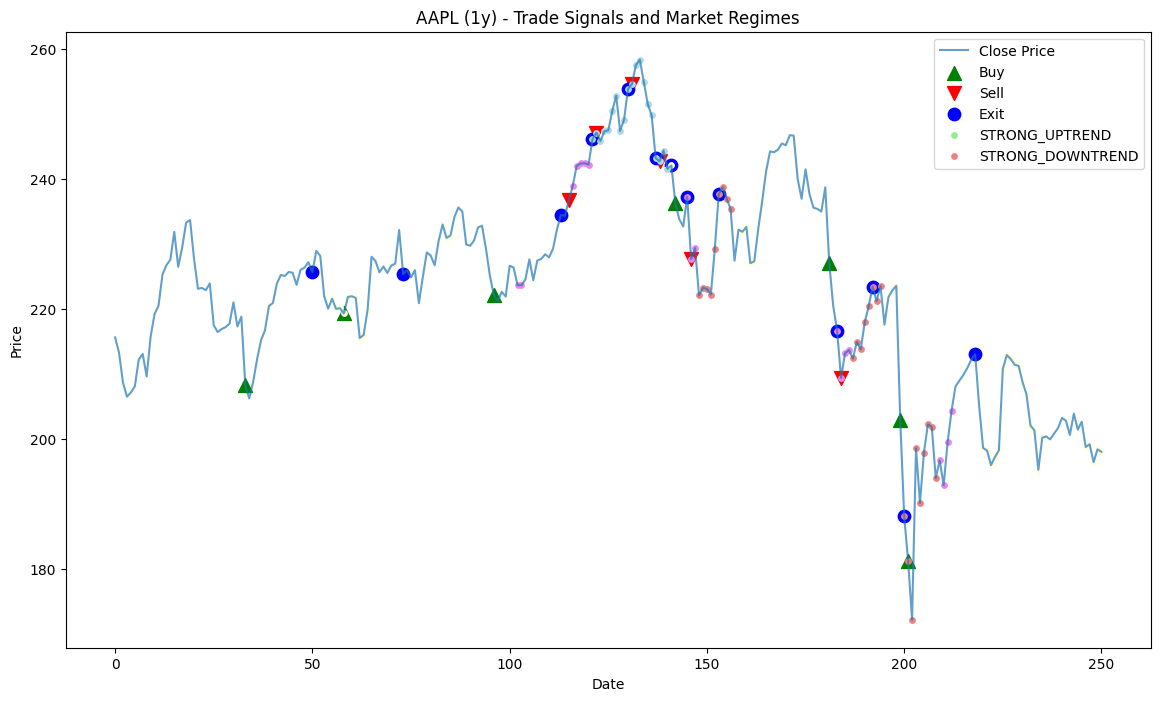

Trades executed: 13
Total Return: 12.98%
Win Rate: 53.85%
Running baseline: AAPL - 2y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/AAPL_2y.csv
Running baseline: MSFT - 1y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/MSFT_1y.csv
Visualizing MSFT (1y)


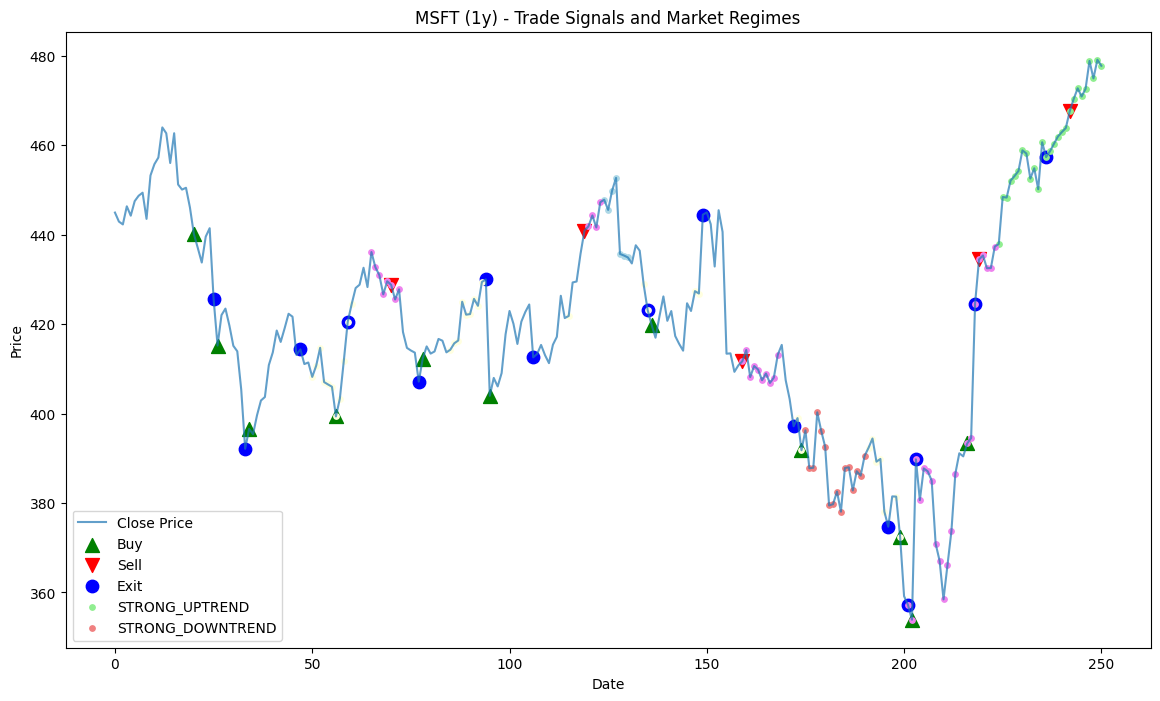

Trades executed: 15
Total Return: 21.44%
Win Rate: 66.67%

First 3 trades:
Trade 1:
  Entry: 440.15 at 2024-07-17 00:00:00
  Exit: 425.63 at 2024-07-24 00:00:00
  P&L: -3.30%, Reason: EXIT_STOP
Trade 2:
  Entry: 415.22 at 2024-07-25 00:00:00
  Exit: 398.41 at 2024-08-05 00:00:00
  P&L: -4.05%, Reason: EXIT_STOP
Trade 3:
  Entry: 396.57 at 2024-08-06 00:00:00
  Exit: 410.25 at 2024-08-23 00:00:00
  P&L: 3.45%, Reason: EXIT_STOP
Running baseline: MSFT - 2y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/MSFT_2y.csv
Running baseline: SPY - 1y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/SPY_1y.csv
Visualizing SPY (1y)


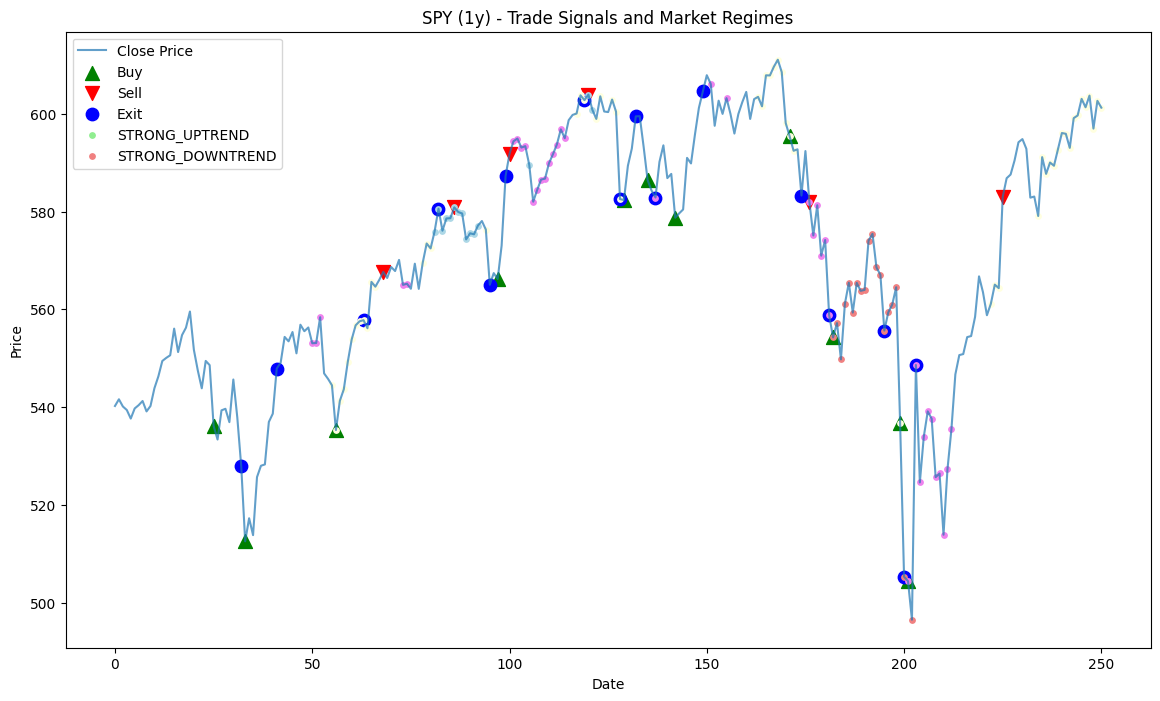

Trades executed: 16
Total Return: 20.40%
Win Rate: 62.50%

First 3 trades:
Trade 1:
  Entry: 536.15 at 2024-07-24 00:00:00
  Exit: 525.09 at 2024-08-02 00:00:00
  P&L: -2.06%, Reason: EXIT_STOP
Trade 2:
  Entry: 512.53 at 2024-08-05 00:00:00
  Exit: 543.95 at 2024-08-15 00:00:00
  P&L: 6.13%, Reason: EXIT_PROFIT
Trade 3:
  Entry: 535.29 at 2024-09-06 00:00:00
  Exit: 558.42 at 2024-09-17 00:00:00
  P&L: 4.32%, Reason: EXIT_PROFIT
Running baseline: SPY - 2y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/SPY_2y.csv
Running baseline: GOOGL - 1y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/GOOGL_1y.csv
Visualizing GOOGL (1y)


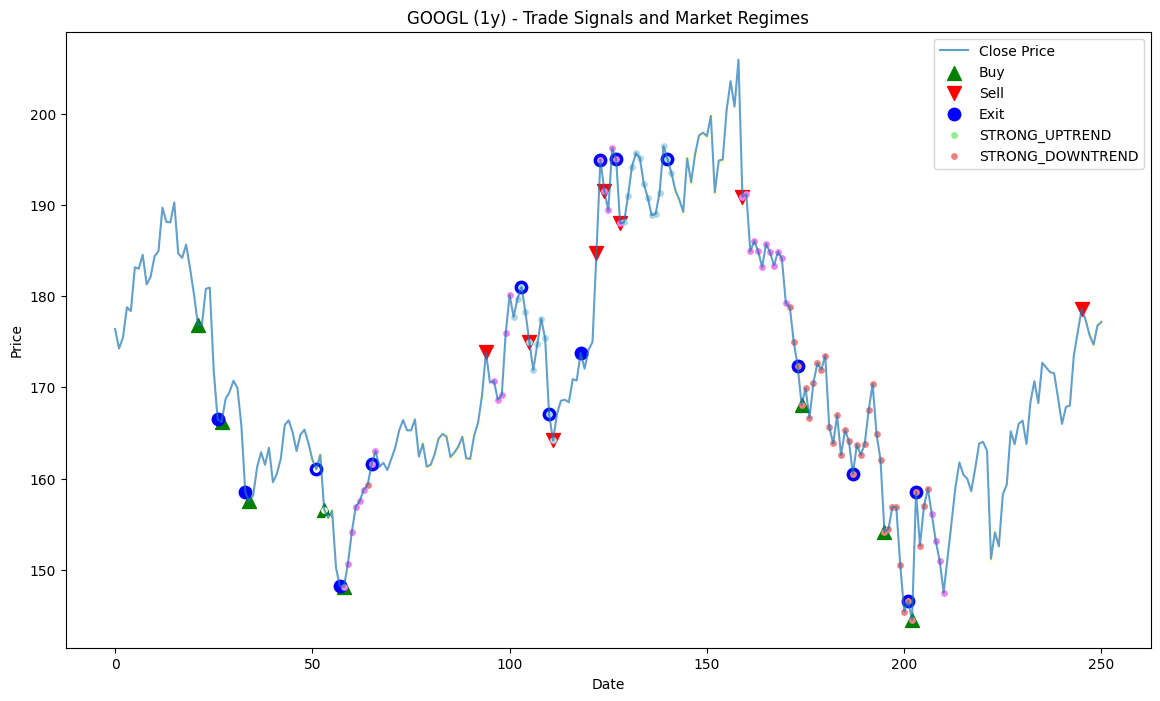

Trades executed: 15
Total Return: -22.30%
Win Rate: 33.33%

First 3 trades:
Trade 1:
  Entry: 176.83 at 2024-07-18 00:00:00
  Exit: 169.51 at 2024-07-25 00:00:00
  P&L: -4.14%, Reason: EXIT_STOP
Trade 2:
  Entry: 166.19 at 2024-07-26 00:00:00
  Exit: 157.81 at 2024-08-05 00:00:00
  P&L: -5.05%, Reason: EXIT_STOP
Trade 3:
  Entry: 157.53 at 2024-08-06 00:00:00
  Exit: 160.13 at 2024-08-29 00:00:00
  P&L: 1.65%, Reason: EXIT_STOP
Running baseline: GOOGL - 2y
Looking for file at: /workspaces/anomaly_trading_algorithm/data/processed/GOOGL_2y.csv

✅ Baseline results saved to backtests/results/baseline/baseline_results.json


In [10]:
# Cell 4: Run Baseline with Debug
# Set debug_first=True to enable debug for first symbol/period
baseline = establish_baseline(debug_first=True)

In [11]:
# Cell 5: Review Baseline Metrics
print("\n=== BASELINE PERFORMANCE SUMMARY ===")
for key, result in baseline.items():
    print(f"\n{key}:")
    print(f"  Total Return: {result['total_return']:.2f}%")
    print(f"  Sharpe Ratio: {result['sharpe_ratio']:.2f}")
    print(f"  Max Drawdown: {result['max_drawdown']:.2f}%")
    print(f"  Win Rate: {result['win_rate']:.2%}")
    print(f"  Profit Factor: {result['profit_factor']:.2f}")
    print(f"  Trades: {result['total_trades']}")


=== BASELINE PERFORMANCE SUMMARY ===

AAPL_1y:
  Total Return: 12.98%
  Sharpe Ratio: 2.29
  Max Drawdown: 21.46%
  Win Rate: 53.85%
  Profit Factor: 1.45
  Trades: 13

AAPL_2y:
  Total Return: 28.95%
  Sharpe Ratio: 2.76
  Max Drawdown: 21.46%
  Win Rate: 51.72%
  Profit Factor: 1.52
  Trades: 29

MSFT_1y:
  Total Return: 21.44%
  Sharpe Ratio: 5.00
  Max Drawdown: 8.91%
  Win Rate: 66.67%
  Profit Factor: 1.94
  Trades: 15

MSFT_2y:
  Total Return: 24.79%
  Sharpe Ratio: 2.83
  Max Drawdown: 25.01%
  Win Rate: 56.25%
  Profit Factor: 1.48
  Trades: 32

SPY_1y:
  Total Return: 20.40%
  Sharpe Ratio: 6.85
  Max Drawdown: 4.09%
  Win Rate: 62.50%
  Profit Factor: 2.53
  Trades: 16

SPY_2y:
  Total Return: -7.71%
  Sharpe Ratio: -1.25
  Max Drawdown: 21.69%
  Win Rate: 37.50%
  Profit Factor: 0.84
  Trades: 40

GOOGL_1y:
  Total Return: -22.30%
  Sharpe Ratio: -4.36
  Max Drawdown: 24.07%
  Win Rate: 33.33%
  Profit Factor: 0.56
  Trades: 15

GOOGL_2y:
  Total Return: -23.83%
  Sharpe R

In [12]:
import pickle
import json
from datetime import datetime

# Create state package
collaboration_state = {
    "project": "Trading Algorithm Optimization",
    "stage": "Baseline Established",
    "timestamp": datetime.now().isoformat(),
    "algorithm": "AdvancedTradingAlgorithm",
    "key_files": {
        "strategy": "strategies/current_algo.py",
        "baseline_results": "backtests/results/baseline/baseline_results.json",
        "notebook": "notebooks/00_baseline_establishment.ipynb"
    },
    "performance_summary": baseline  # Your baseline results variable
}

# Save to file
with open("collaboration_state.pkl", "wb") as f:
    pickle.dump(collaboration_state, f)

print("✅ Collaboration state saved to collaboration_state.pkl")
print("Please download and share this file in our next chat session")

✅ Collaboration state saved to collaboration_state.pkl
Please download and share this file in our next chat session
